In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import gc
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output
seed = 2019

/kaggle/input/wns-analyticswizard/test_aq1fgdb/test.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/view_log.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/item_data.csv
/kaggle/input/wns-analyticswizard/train_na17sgz/train.csv
/kaggle/input/wns-analyticswizard/sample_submission_ipsblct/sample_submission.csv
/kaggle/input/wns-analytics-wizard-making-train-test/__output__.json
/kaggle/input/wns-analytics-wizard-making-train-test/__notebook__.ipynb
/kaggle/input/wns-analytics-wizard-making-train-test/wns_train.csv
/kaggle/input/wns-analytics-wizard-making-train-test/__results__.html
/kaggle/input/wns-analytics-wizard-making-train-test/custom.css
/kaggle/input/wns-analytics-wizard-making-train-test/wns_test.csv


In [2]:
train = pd.read_csv('../input/wns-analytics-wizard-making-train-test/wns_train.csv', parse_dates = ['impression_time'])
view_log = pd.read_csv('../input/wns-analyticswizard/train_na17sgz/view_log.csv', parse_dates = ['server_time'])
item_data = pd.read_csv('../input/wns-analyticswizard/train_na17sgz/item_data.csv')
test = pd.read_csv('/kaggle/input/wns-analytics-wizard-making-train-test/wns_test.csv', parse_dates = ['impression_time'])

In [3]:
train = train.sort_values(by='impression_time')
view_log = view_log.sort_values(by='server_time')
test = test.sort_values(by='impression_time')

In [4]:
train.head()

,app_code,date,hour,impression_id,impression_time,is_4G,is_click,minute,month,os_version,user_id,ad_iter,ad_delta,item_id,time_elapsed,total_visits
0,422,15,0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,0,0.0,0,11,old,87862,1.0,NaN,43886.0,37789.0,1.0
1,129,15,0,c81e728d9d4c2f636f067f89cc14862c,2018-11-15 00:00:00,0,0.0,0,11,intermediate,89464,1.0,NaN,30152.0,76.0,3.0
2,127,15,0,eccbc87e4b5ce2fe28308fd9f2a7baf3,2018-11-15 00:00:00,0,0.0,0,11,latest,58442,1.0,NaN,73224.0,6008.0,8.0
3,371,15,0,a87ff679a2f3e71d9181a67b7542122c,2018-11-15 00:00:00,0,0.0,0,11,latest,4238,1.0,NaN,72955.0,642.0,3.0
14,190,15,0,8f14e45fceea167a5a36dedd4bea2543,2018-11-15 00:01:00,0,0.0,1,11,old,30371,1.0,NaN,216.0,6381.0,1.0


In [5]:
test.head()

,app_code,date,hour,impression_id,impression_time,is_4G,minute,month,os_version,user_id,ad_iter,ad_delta,item_id,time_elapsed,total_visits
0,207,12,0,baf48d04f9e742bc9b300291caafe986,2018-12-12,0,0,12,intermediate,81444,1.0,NaN,81838.0,120.0,2.0
1,7,12,0,a262ad869b347553956e2f460362d837,2018-12-12,0,0,12,latest,32684,9.0,2864.0,42209.0,187.0,1.0
2,390,12,0,3f964522e5a8a051b04fa97f145e0d55,2018-12-12,1,0,12,intermediate,75720,1.0,NaN,111805.0,679.0,1.0
3,470,12,0,4d1534b976ee10cbb1390f9d3adb3646,2018-12-12,1,0,12,intermediate,1838,7.0,-44.0,87780.0,808.0,1.0
4,129,12,0,ee0a836f8620592791fe33a629eb8d17,2018-12-12,0,0,12,intermediate,72729,6.0,48.0,95249.0,3317.0,1.0


In [6]:
X = pd.get_dummies(train['os_version'])
train = train.drop('os_version',1)
train = pd.concat([train, X], axis=1)

X = pd.get_dummies(test['os_version'])
test = test.drop('os_version',1)
test = pd.concat([test, X], axis=1)

In [7]:
# mapping = {'old': 0, 'intermediate' : 1, 'latest':2}

# train['os_version'] = train['os_version'].map(mapping)
# test['os_version'] = test['os_version'].map(mapping)

In [8]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
13,2018-10-15 08:58:00,android,876311,35913,15434
12,2018-10-15 08:58:00,android,585539,39617,22859
11,2018-10-15 08:58:00,android,264366,34712,11871
9,2018-10-15 08:58:00,android,941129,31754,127900


In [9]:
target = train['is_click']
train = train.drop(['impression_id','impression_time','is_click','time_elapsed'],1)

test = test.drop(['impression_id','impression_time','time_elapsed'], 1)

In [10]:
# def group_noise(col):
#     valid = train[col].value_counts()
#     valid = valid[valid>10].index
    
#     train[col] = np.where(train[col].isin(valid),train[col],np.nan)
#     test[col] = np.where(test[col].isin(valid),test[col],np.nan)
    
#     return train[col], test[col]

In [11]:
# train['ad_iter'], test['ad_iter'] = group_noise('ad_iter')

In [12]:
n_folds = 5
skfold = StratifiedKFold(n_splits = n_folds, random_state = seed)
kfold = KFold(n_splits = n_folds, random_state = seed)

oof = np.zeros(len(train))
pred = np.zeros(len(test))
scores=[]
feat_imp = pd.DataFrame()
feat_imp['features'] = train.columns
feat_imp['importance'] = 0

In [13]:


for fold_n, (train_index, valid_index) in enumerate(skfold.split(train, target)):
    
    print('Fold ',fold_n + 1)
    
    xgbclf = XGBClassifier(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.1,
        subsample=1,
        colsample_bytree=1,
        random_state = seed
#         tree_method='gpu_hist'  # THE MAGICAL PARAMETER
    )
    
    X_train_, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train_, y_valid = target.iloc[train_index], target.iloc[valid_index]
    xgbclf.fit(X_train_,y_train_, early_stopping_rounds = 50, eval_set=[(X_train_,y_train_),(X_valid, y_valid)], eval_metric = 'auc', verbose = 50)
    del X_train_,y_train_
    pred += xgbclf.predict_proba(test)[:,1]/n_folds
    val=xgbclf.predict_proba(X_valid)[:,1]
    oof[valid_index] = val
    scores.append(roc_auc_score(y_valid, val))
    feat_imp['importance'] += xgbclf.feature_importances_/n_folds
    del xgbclf, X_valid
    print('ROC accuracy: {}'.format(roc_auc_score(y_valid, val)))
    del val,y_valid
    gc.collect()

print('Mean CV ', np.mean(scores))

Fold  1
[0]	validation_0-auc:0.650813	validation_1-auc:0.656757
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.682217	validation_1-auc:0.66931
[100]	validation_0-auc:0.703526	validation_1-auc:0.684167
[150]	validation_0-auc:0.714741	validation_1-auc:0.641954
Stopping. Best iteration:
[143]	validation_0-auc:0.711545	validation_1-auc:0.686667

ROC accuracy: 0.686666607472382
Fold  2
[0]	validation_0-auc:0.653475	validation_1-auc:0.646277
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[50]	validation_0-auc:0.685718	validation_1-auc:0.663076
[100]	validation_0-auc:0.7066	validation_1-auc:0.675253
Stopping. Best iteration:
[96]	validation_0-auc:0.704769	validation_1-auc:0.677431

ROC accuracy: 0.6774306957543998
Fold  3
[0]	validation_0-auc:0.64692	va

In [14]:
sub = pd.read_csv('../input/wns-analyticswizard/sample_submission_ipsblct/sample_submission.csv')
sub['is_click'] = pd.Series(pred)
sub.to_csv('fourth_sub.csv', index=False)

In [15]:
feat_imp.to_csv('Feat_imp_sub4.csv',index=False)

Text(0.5, 1.0, 'Feature Importances')

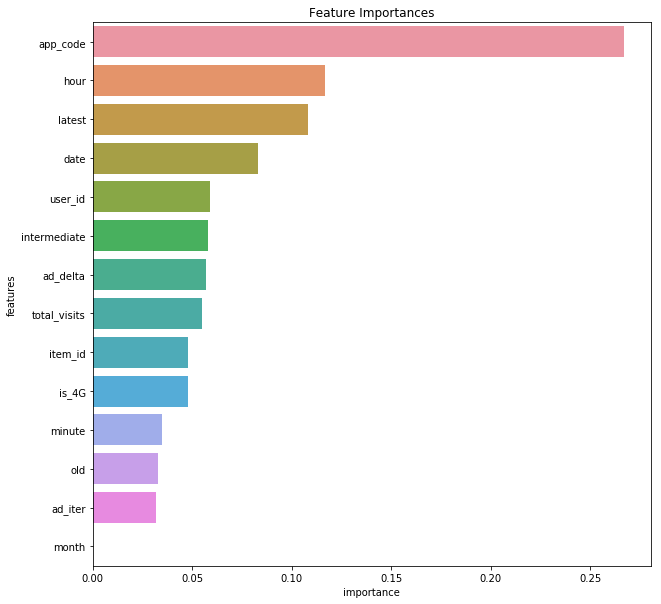

In [16]:
df=feat_imp.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(data= df, x=df['importance'], y=df['features'])
plt.title('Feature Importances')